#Random Forest To Predict the Winner

Given the data that we gathered from Riot's database, we wanted to figure out which features would be important to look at to predict the winning team. **Random Forest** is a useful tool to figure out how important each features were, based on how many decision trees they are found in. 

Random Forests is powerful because it is unexcelled in accuracy among current algorithms, runs efficiently on large data bases, and is able to give the relative importance of each variable that we are testing. 


In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

We've created a csv file using a package called 'Cassiopeia', which is used to query and parse through data we've obtained from Riot's database. We'll read in this csv file and create a **panda dataframe**. We'll print the head of the dataframe to see what we're working with.


In [7]:
dftouse = pd.read_csv('newdf.csv')
dftouse.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffkda,diffrange,diffspree,difftank,fbaron,fblood,fdrag,finhib,fturret,win
0,1,819,155,17067,3,17703,18.144444,-1,5,0,True,False,True,True,False,True
1,1,-685,24,-23447,0,-11396,-20.117208,1,-7,1,True,False,True,False,False,False
2,-1,658,16,-5988,0,-11734,-21.416667,1,-3,1,False,True,True,False,True,False
3,-1,-339,-127,-9102,-2,-17661,-17.531349,1,-6,0,False,False,False,False,False,False
4,0,756,162,12505,0,11899,26.059524,0,3,3,False,False,False,True,True,True


In [8]:
cols = list(dftouse.columns)

In [9]:
print cols

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'fbaron', 'fblood', 'fdrag', 'finhib', 'fturret', 'win']


<span style = "font-size: 1.5em;">Getting on with the classifier</span>

Now, let's get on with our random forest classifier.

First we want to create mask values so we can split the dataframe into training and testing sets. To do that we import `train_test_split`, and create mask values.

In [10]:
###Random forest classifier
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.75)

In [11]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [12]:
#seeing if it worked out correctly
mask.shape, mask.sum()

((20223,), 15167)

We define lcols to be the columns of the variables that we want to know about. We do this by creating a list of the our column names and then removing 'win' as that is the response variable.

In [13]:
#Now we will be using a Random Forest classifier to figure out which features are more 
#important in determining the probability of a team winning. First, we split the data set.

#columns with values to fit as the X values
lcols = list(dftouse.columns.values)
#removing the win (y) response variables from the list
lcols.remove('win')
print(lcols)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'fbaron', 'fblood', 'fdrag', 'finhib', 'fturret']


Don't forget to `import` the `RandomForestClassifier`!

In [14]:
from sklearn.ensemble import RandomForestClassifier

First, we'll create a `RandomForestClassifier` with the default parameters that we can use to optimize later.

In [15]:
clfForest = RandomForestClassifier()

We define two functions: `cv_optimize` and `do_classify`, derived from pset3.

`cv_optimize` takes in:
* clf as the original classifer (which in our case is clfForest) 
* the parameters to search over (we will be optimizing the n_estimator parameter)
* The X training matrix
* The y training vector

It returns the *best* parameter, according to the score.

`do_classify` uses `cv_optimize` and outputs the **X training matrix, y training vector, X test matrix, y test vector, the new optimized and fitted classifier, and the accuracy of the new model on the training and test sets**.

`do_classify` takes in:
* indf as the input dataframe (dftouse)
* featurenames as the variables we want to test (lcols)
* targetname as the variable we want predict (win)
* mask, the boolean vector indicator test set
* n_jobs, used for parallelization
* score_func, algorithm used to determine score

In [17]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split =None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

We want to optimize `n_estimators`, which is the number of trees in the forest. We wanted a large number of trees in the forest so we can better identify which features are more important; so we'll test to see up to 99 trees. Then, we'll run `do_classify`.

In [19]:
parameters = {"n_estimators": range(1, 100)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       dftouse, lcols, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 89} 0.978294941387 [mean: 0.96036, std: 0.00697, params: {'n_estimators': 1}, mean: 0.96372, std: 0.00277, params: {'n_estimators': 2}, mean: 0.97101, std: 0.00261, params: {'n_estimators': 3}, mean: 0.97229, std: 0.00386, params: {'n_estimators': 4}, mean: 0.97532, std: 0.00194, params: {'n_estimators': 5}, mean: 0.97492, std: 0.00343, params: {'n_estimators': 6}, mean: 0.97550, std: 0.00251, params: {'n_estimators': 7}, mean: 0.97629, std: 0.00211, params: {'n_estimators': 8}, mean: 0.97610, std: 0.00202, params: {'n_estimators': 9}, mean: 0.97526, std: 0.00286, params: {'n_estimators': 10}, mean: 0.97759, std: 0.00335, params: {'n_estimators': 11}, mean: 0.97630, std: 0.00209, params: {'n_estimators': 12}, mean: 0.97589, std: 0.00260, params: {'n_estimators': 13}, mean: 0.97705, std: 0.00337, params: {'n_estimators': 14}, mean: 0.97766, std: 0.00267, params: {'n_estimators': 15}, mean: 0.97701, std: 0.00186, params: {'n_estimators': 16}, mean: 0.97737, std: 0.0

The best parameter value is 89, with a score of 0.978. Let's print the clfForest to see its features.

In [20]:
clfForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=89, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's store the training and test sets in `reuse_split` so we can use them later with consistent sets.

In [21]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

<span style = "font-size: 1.34em"> Visualizing the results <span>

We'll first visualize the relative importance of each feature. The importances sum up to 1, which gives us an interesting insight into how important each feature was in predicting the winner. `feature_importances` returns the importances.

In [22]:
#We can plot the importances
importances = clfForest.feature_importances_

We'll sort the importances and column names so they match up.

In [23]:
imp_sort, lcols_sort = zip(*sorted(zip(importances, lcols)))

We'll use a horizontal bar chart to compare the importances. 

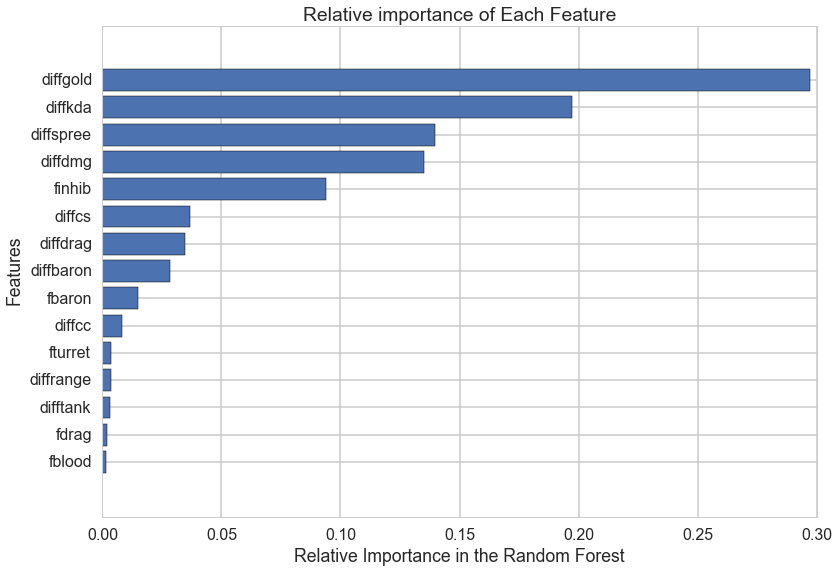

In [24]:
#plot importances
plt.barh(range(len(lcols_sort)),imp_sort,align='center')
plt.yticks(range(len(lcols_sort)),lcols_sort)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

We see that the results show us that the five most important variables in predicting the winner of the game are difference in gold earned, difference in kill-death-assist ratio, who got the first inhib, difference in damage dealt to champions, and difference in the number of killing sprees. Comparatively, we see that difference in the number of type of champions, such as "tank" and "ranged", were very weak variables, as well as who got first blood and who got first turret. 

Let's create some more visuals to see how these visuals interact with the wins. First, let's make a new dataframe with only the blue team wins, and a new dataframe with only red team wins.

In [25]:
bluewins = dftouse.query('win == True')
redwins = dftouse.query('win == False')

First, we plotted a histogram of the gold difference (in thousands) of all games. Positive values indicate that blue team had more gold amassed.

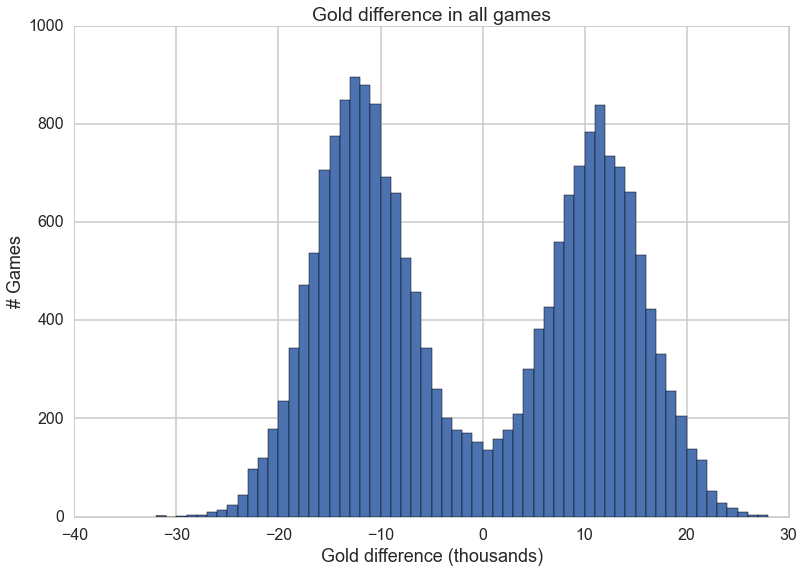

In [26]:
#all games
plt.hist(np.array(dftouse['diffgold'])/1000, bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('Gold difference (thousands)', fontsize = 18)
plt.title('Gold difference in all games')

We see that the resulting histogram shows 2 almost normally distributed curves, centered around about 12,000 and -12,000. This is probably because of how important gold difference is in predicting the winner of the game. We then plot the blue team wins and red team wins side by side to see if this is really the case. Once again, positive values indicate that the blue team had more gold.

/Users/leosjk/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


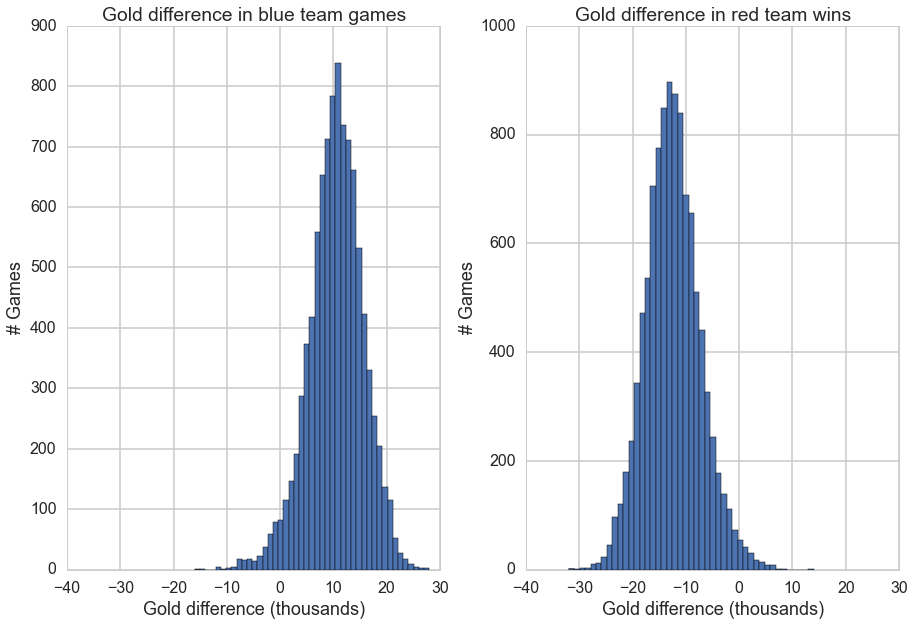

In [27]:
#Plotting side by side
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, tight_layout = True)
#blue team win
ax1.hist(np.array(bluewins['diffgold'])/1000, bins = 45)
ax1.set_ylabel('# Games', fontsize = 18)
ax1.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax1.set_title('Gold difference in blue team games')
#red team wins
ax2.hist(np.array(redwins['diffgold'])/1000, bins = 45)
ax2.set_ylabel('# Games', fontsize = 18)
ax2.set_ylim((0,1000))
ax2.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax2.set_title('Gold difference in red team wins')

We see our prediction is correct - almost all the games that the blue team won, the gold difference is positive, while almost all the games that the red team won, the gold difference is negative (meaning red team had more gold). This provides us a visual into how gold difference is a good predictor to see who won the round at the end of the game. Let's do a kernel-density plot to see how they overlap.

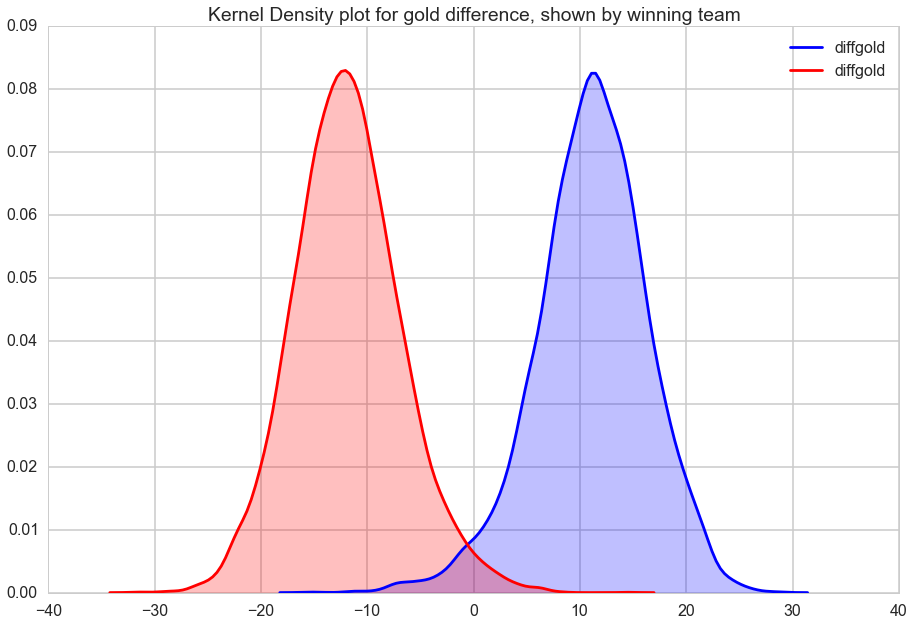

In [60]:
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for gold difference, shown by winning team")

We try this with the difference in kill-death-assist ratios as well. First, we graph all games.

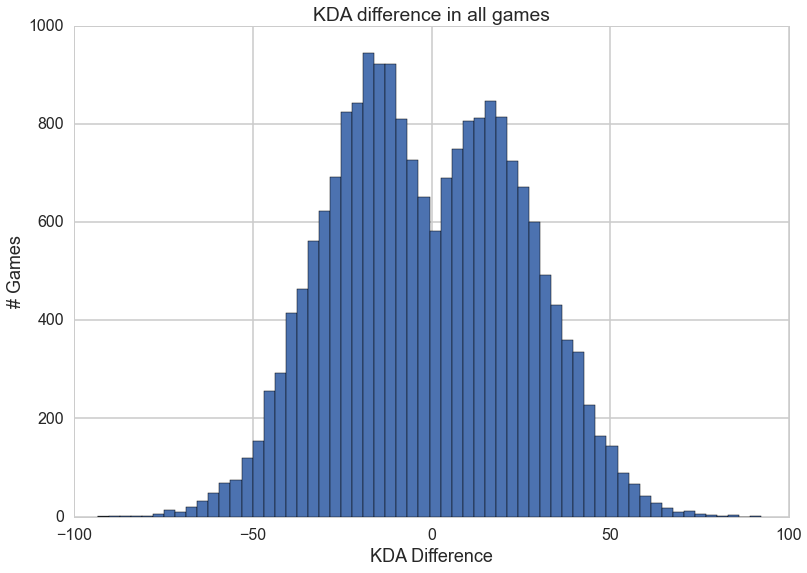

In [28]:
#all games
plt.hist(np.array(dftouse['diffkda']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('KDA Difference', fontsize = 18)
plt.title('KDA difference in all games')

The histogram above does not show the same amount of differentiation, per se, of the KDA differences between the blue and red teams. Nonetheless, the shape of the histogram, especially between -30 to 30, show that there might be some importance. Let's plot the blue team wins and red team wins side by side, using the KDA difference. Once again, positive values means the blue team has a higher KDA ratio.

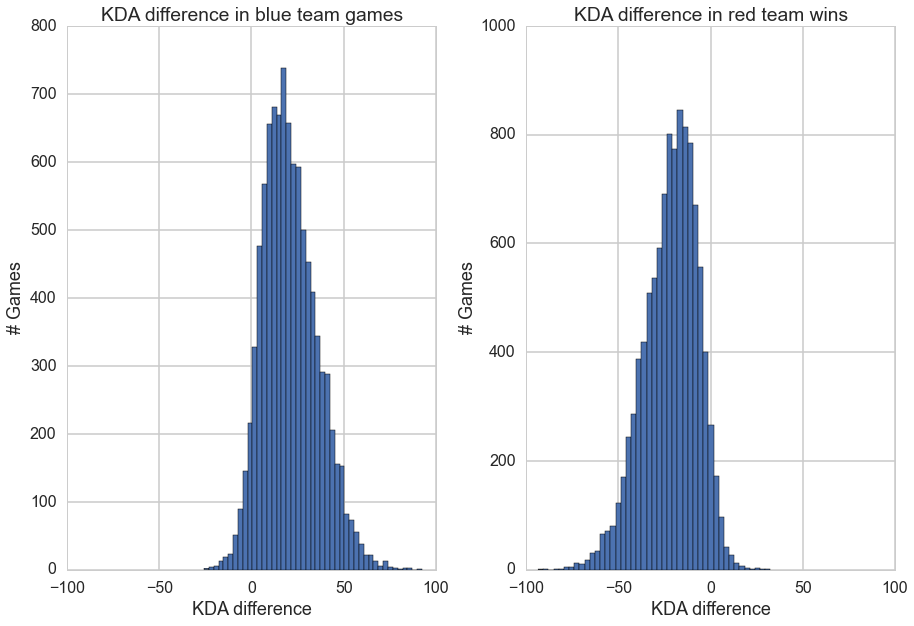

In [29]:
#Plotting side by side
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, tight_layout = True)
#blue team win
ax1.hist(np.array(bluewins['diffkda']), bins = 45)
ax1.set_ylabel('# Games', fontsize = 18)
ax1.set_xlabel('KDA difference', fontsize = 18)
ax1.set_title('KDA difference in blue team games')
#red team wins
ax2.hist(np.array(redwins['diffkda']), bins = 45)
ax2.set_ylabel('# Games', fontsize = 18)
ax2.set_ylim((0,1000))
ax2.set_xlabel('KDA difference', fontsize = 18)
ax2.set_title('KDA difference in red team wins')

We see that the two histograms show that KDA difference is important, but not as important as gold difference, as there is a bit of a skew to the right on blue team wins and a bit of a skew to the left on red team wins. We see that the two histograms are not starkly separated like the gold difference histograms, with many matches more towards the middle of the joint histogram. Let's look at the KDE plot to compare the two.

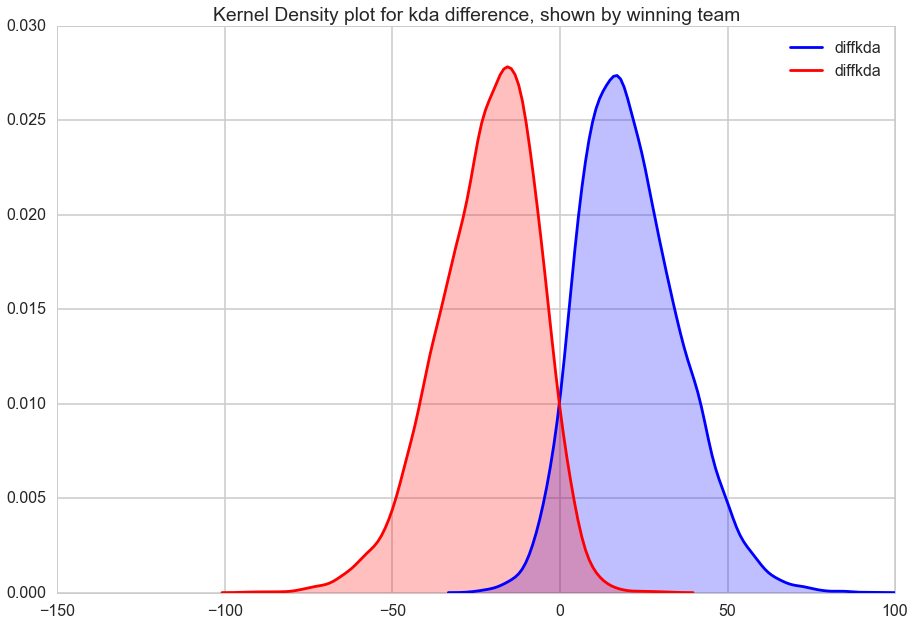

In [63]:
#KDE plot
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins['diffkda'], ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins['diffkda'], ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for kda difference, shown by winning team")

The KDE plot shows that there overlap, with the "peaks" of the curves much closer to each other than the gold difference.

Next, we plot the top indicator variable, `finhib`, which returns `True` if blue team destroyed an inhibitor first, and `False` if red team destroyed an inhibitor first. Let's do a histogram that compares blue team wins versus red team wins, marked by who got the first inhibitor.

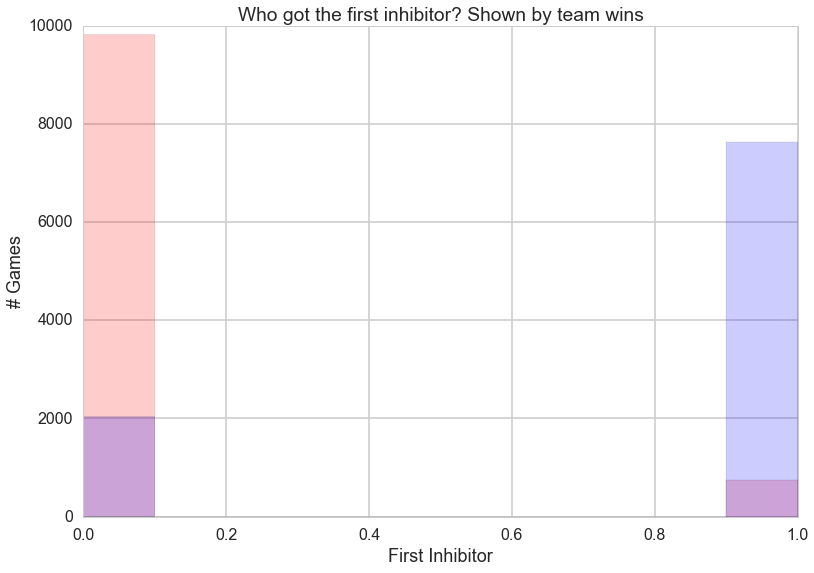

In [71]:
#all games, shown by team wins
plt.hist(np.array(redwins['finhib']), color = 'r', alpha = 0.2)
plt.hist(np.array(bluewins['finhib']), color = 'b', alpha = 0.2)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Inhibitor', fontsize = 18)
plt.title('Who got the first inhibitor? Shown by team wins')

We see that while there are quite a few games where the other team got the first inhibitor, our data shows that the majority of the wins are correlated with who got the first inhibitor.

Finally, let's look at two variables, "first blood" indicator and difference in duration of crowd control spells, that were shown to be "not important" by the random forest.

We'll use the kernel density plot for the `diffcc` variable:

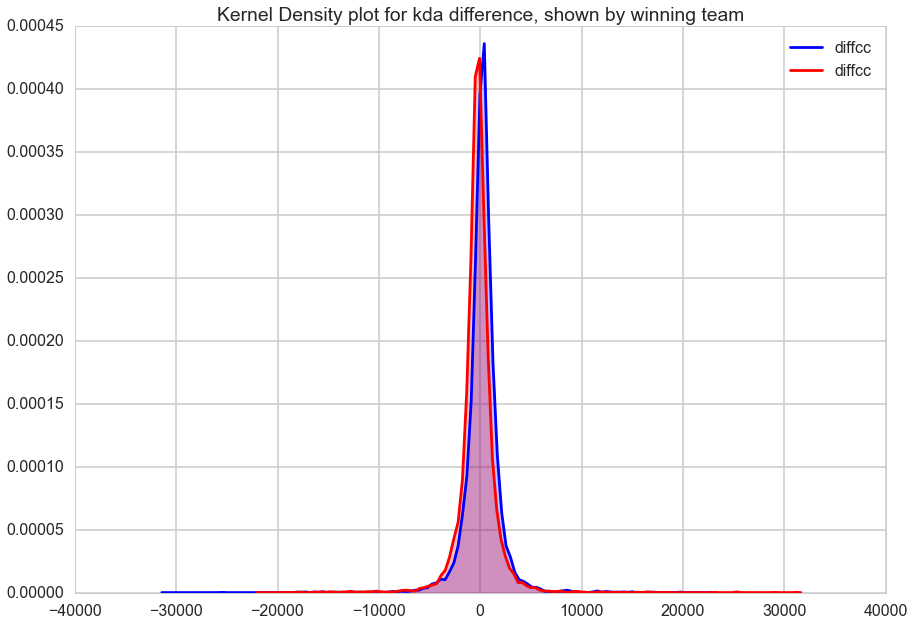

In [67]:
#KDE plot
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins['diffcc'], ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins['diffcc'], ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for kda difference, shown by winning team")

We see that there is much overlap, indicating that this variable would not be helpful in predicting the winner. Next, let's look at "first blood".

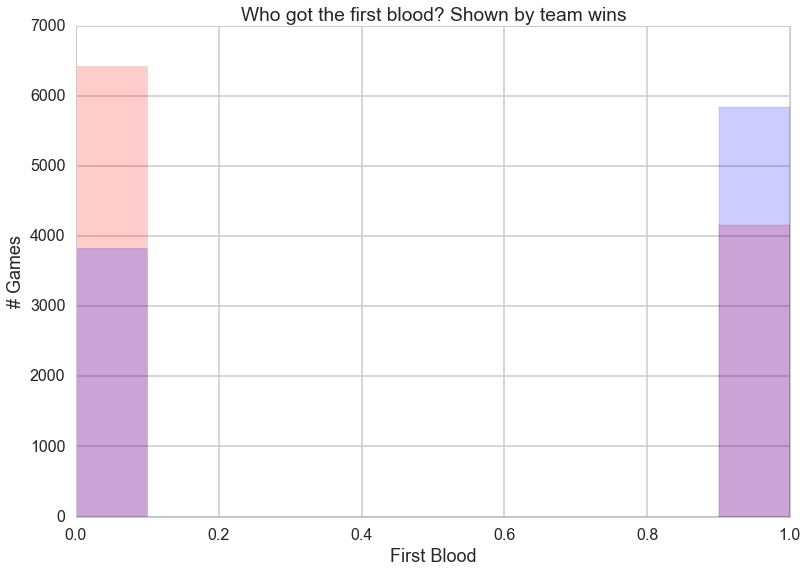

In [70]:
#all games, shown by team wins
plt.hist(np.array(redwins['fblood']), color = 'r', alpha = 0.2)
plt.hist(np.array(bluewins['fblood']), color = 'b', alpha = 0.2)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Blood', fontsize = 18)
plt.title('Who got the first blood? Shown by team wins')

We see that there are many games where the red team won without getting first blood, and there are many games where the blue team lost even after first blood. First blood isn't a good indicator.

<span style = "font-size: 1.2em"> Using a standardized data set </span>

We then standardized the dataset, to account for variability.

In [31]:
stddf = dftouse.copy()
stddf.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffkda,diffrange,diffspree,difftank,fbaron,fblood,fdrag,finhib,fturret,win
0,1,819,155,17067,3,17703,18.144444,-1,5,0,True,False,True,True,False,True
1,1,-685,24,-23447,0,-11396,-20.117208,1,-7,1,True,False,True,False,False,False
2,-1,658,16,-5988,0,-11734,-21.416667,1,-3,1,False,True,True,False,True,False
3,-1,-339,-127,-9102,-2,-17661,-17.531349,1,-6,0,False,False,False,False,False,False
4,0,756,162,12505,0,11899,26.059524,0,3,3,False,False,False,True,True,True


We'll create a list of variables to standardize.

In [32]:
#Standardizeable variables
stdz = list(dftouse.columns)
stdz.remove('win')
stdz.remove('fblood') 
stdz.remove('finhib')
stdz.remove('fdrag')
stdz.remove('fbaron')
stdz.remove('fturret')
print(stdz)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank']


We'll split the train and test set, using the same mask values we obtained earlier, giving us the same sets, just with standardized values.

In [34]:
#adding mask column
stddf['Mask'] = mask
#trainset to fit and standardize
trainset = stddf.query('Mask == True')
testset = stddf.query('Mask == False')
#test set train set
trainset = trainset[stdz]
testset = testset[stdz]

In [35]:
#standardizing our data
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
preprocessing.StandardScaler().fit(trainset)
fitdf = preprocessing.StandardScaler().fit_transform(stddf[stdz])
newdf = pd.DataFrame(fitdf)
newdf.columns = trainset.columns

In [36]:
#replace values
stddf[stdz] = newdf
stddf.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffkda,diffrange,diffspree,difftank,fbaron,fblood,fdrag,finhib,fturret,win,Mask
0,1.012372,0.427762,1.615697,0.818152,1.487001,1.482770,0.744954,-0.848866,1.306314,-0.005191,True,False,True,True,False,True,False
1,1.012372,-0.346850,0.360326,-1.028140,0.112277,-0.836434,-0.728606,0.857049,-1.736486,0.957995,True,False,True,False,False,False,True
2,-0.875690,0.344841,0.283662,-0.232503,0.112277,-0.863373,-0.778652,0.857049,-0.722219,0.957995,False,True,True,False,True,False,True
3,-0.875690,-0.168648,-1.086705,-0.374414,-0.804205,-1.335757,-0.629018,0.857049,-1.482920,-0.005191,False,False,False,False,False,False,True
4,0.068341,0.395315,1.682778,0.610254,0.112277,1.020188,1.049785,0.004091,0.799181,2.884368,False,False,False,True,True,True,True


Let's split this new dataset.

In [37]:
Xmatrix = stddf[lcols].values
yvals = stddf['win'].values

In [38]:
##split to train and test
X_train = Xmatrix[mask]
X_test = Xmatrix[~mask]
y_train = yvals[mask]
y_test = yvals[~mask]

We'll fit the new set with the RandomForestClassifier from earlier.

In [40]:
#We can graph importances.
#First we fit
fitForest = clfForest.fit(X_train, y_train)

In [41]:
fitForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=89, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's plot the importances.

In [43]:
#We can plot the importances
importances2 = fitForest.feature_importances_

In [45]:
imp_sort2, lcols_sort2 = zip(*sorted(zip(importances2, lcols)))

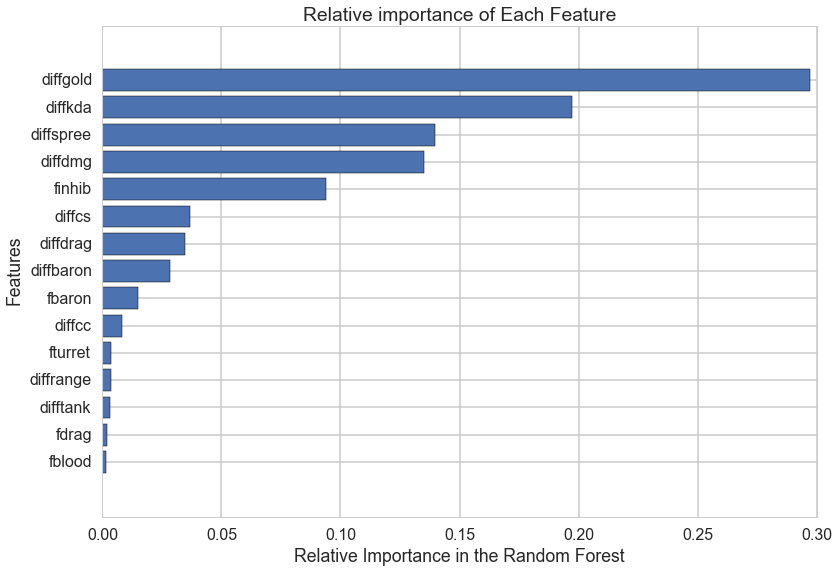

In [46]:
#plot importances
plt.barh(range(len(lcols_sort)),imp_sort,align='center')
plt.yticks(range(len(lcols_sort)),lcols_sort)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

As expected, we see that the variables that our earlier classifier found to be most important are still classified to be important. Let's graph the standardized gold difference values to visualize this quickly. First, histogram of all games:

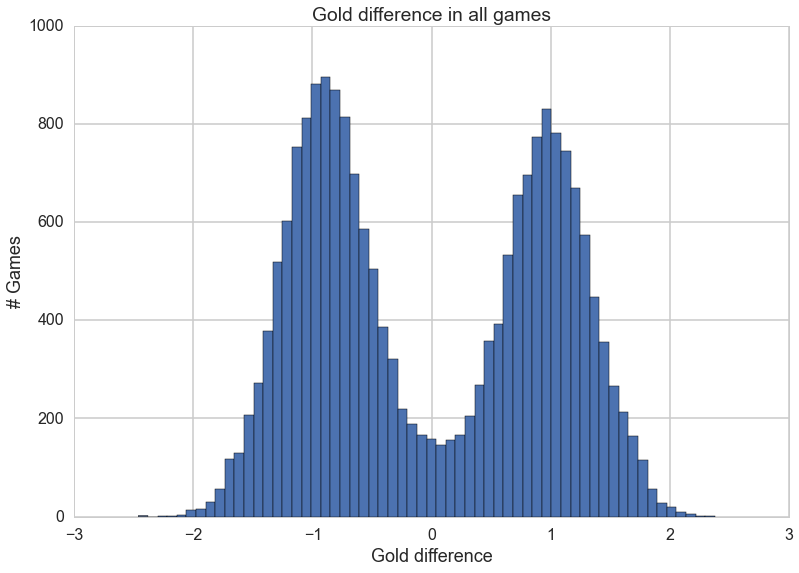

In [50]:
#all games
plt.hist(np.array(stddf['diffgold']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('Gold difference', fontsize = 18)
plt.title('Gold difference in all games')

Side-by-side histograms of gold differences by blue team wins and red team wins:

In [51]:
bluewins2 = stddf.query('win == True')
redwins2 = stddf.query('win == False')

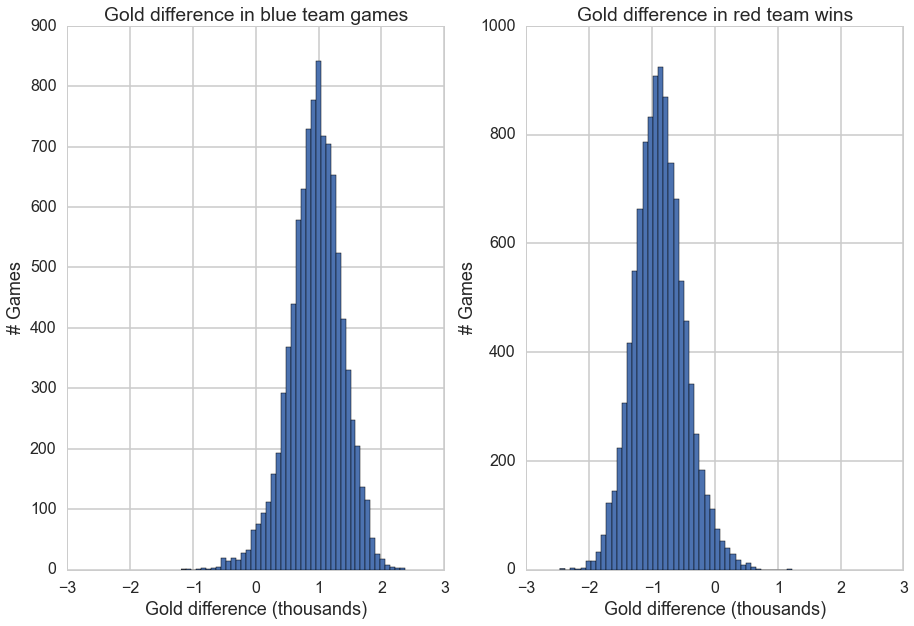

In [52]:
#Plotting side by side
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, tight_layout = True)
#blue team win
ax1.hist(np.array(bluewins2['diffgold']), bins = 45)
ax1.set_ylabel('# Games', fontsize = 18)
ax1.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax1.set_title('Gold difference in blue team games')
#red team wins
ax2.hist(np.array(redwins2['diffgold']), bins = 45)
ax2.set_ylabel('# Games', fontsize = 18)
ax2.set_ylim((0,1000))
ax2.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax2.set_title('Gold difference in red team wins')

And finally, the KDE plot:

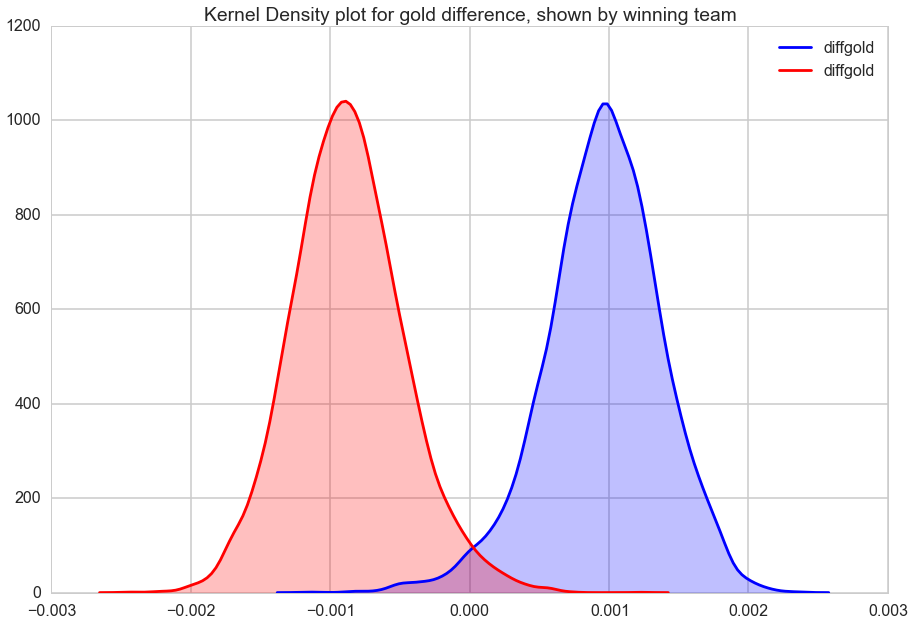

In [64]:
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins2['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins2['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for gold difference, shown by winning team")

Unsurprisingly, we see that the visuals return the same story with slightly different values (as we have standardized them).

#Conclusion, and Moving Forward to the Next Step

The RandomForestClassifier gave us the relative importance of each feature we tested for, and we've identified variables that showed to be very important in predicting the winner. We see that the top five variables (difference in gold, difference in kill-death-assist ratio, difference in killing spree, difference in damage dealt to champions, and who got the first inhibitor) seem to be far more important than things like who got first blood or what the difference in creep score is. This makes sense. For example, the KDA ratio shows how many champion kills the teams obtained. Gold is correlated to win conditions (inhibitors and turrets), as well as champion kills and creep scores. More gold allows for more powerups, which makes the team with more gold more powerful, and more likely to win.

Next, we see that our model on the training set has an accuracy of 100%, while on the test test it shows an accuracy of 98%. However, this accuracy is *too high*. This is because the features we look at to be important (beyond the indicator variables of things like "first inhibitor") are values from the **end of the round**, which makes it almost a redundant prediction, as the team with *more kills and more gold* is almost certainly the team that will win.

In order to improve our model, we've decided to next look at important features, such as gold difference, at certain timestamps in the game to predict the end results. That is the next step we took.